# Stage 11 Homework — Evaluation & Risk Communication
In the lecture, we learned **parametric vs bootstrap CIs**, **scenario sensitivity**, and **subgroup checks**.
Now, you will adapt those methods to your dataset and produce assumption-aware results.

In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

## Load Data (provided or synthetic fallback)

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

csv_path = data_dir / 'data_stage11_eval_risk.csv'

if csv_path.exists():
    try:
        df = pd.read_csv(csv_path, parse_dates=['date'])
    except ValueError as e:
        print(f"Error reading CSV: {e}\nRegenerating synthetic data...")
        regenerate = True
    else:
        regenerate = False
else:
    regenerate = True

if regenerate:
    n = 180
    dates = pd.date_range('2022-06-01', periods=n, freq='D')
    seg = np.random.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
    x = np.linspace(0, 9, n) + np.random.normal(0, 0.7, n)
    y = 2.1 * x + 0.8 + np.random.standard_t(df=3, size=n) * 1.1
    x[np.random.choice(np.arange(n), size=round(0.05*n), replace=False)] = np.nan
    df = pd.DataFrame({'date': dates, 'segment': seg, 'x_feature': x, 'y_target': y})
    df.to_csv(csv_path, index=False)

df.head()


,date,segment,x_feature,y_target
0,2022-06-01,B,0.547868,2.107524
1,2022-06-02,A,0.974480,2.209111
2,2022-06-03,A,-0.012991,0.867315
3,2022-06-04,B,-1.012503,-1.741932
4,2022-06-05,A,0.642399,1.615007


## Helper Functions (complete or modify as needed)

In [4]:
def mean_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmean(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

def median_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmedian(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), np.array([float(beta[1])])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_[0] * X.ravel()

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def bootstrap_metric(y_true, y_pred, fn, n_boot=500, seed=111, alpha=0.05):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': float(np.mean(stats)), 'lo': float(lo), 'hi': float(hi)}

def fit_fn(X, y):
    return SimpleLinReg().fit(X, y)
def pred_fn(model, X):
    return model.predict(X)

## Baseline Fit & Residuals (Required)

In [5]:
X_raw = df['x_feature'].values
y = df['y_target'].values
X_base = mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))
df['x_imputed'] = X_base
base_mae = mae(y, y_hat)
print(f"Baseline MAE: {base_mae:.4f}")

Baseline MAE: 1.2783


## Parametric vs Bootstrap CI (Required)

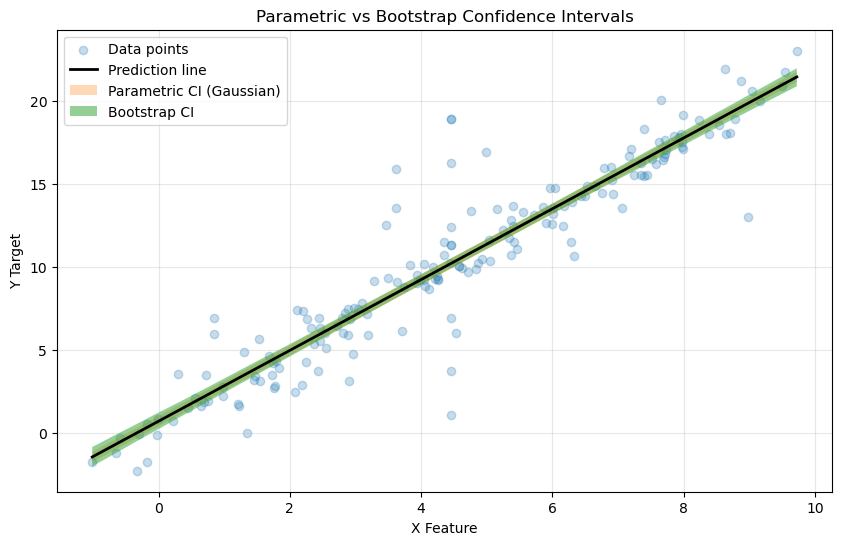

In [6]:
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)
gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

plt.figure(figsize=(10, 6))
plt.scatter(X_base, y, alpha=0.25, label='Data points')
plt.plot(x_grid, pred_line, 'k-', label='Prediction line', linewidth=2)
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.3, label='Parametric CI (Gaussian)')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.5, label='Bootstrap CI')
plt.xlabel('X Feature')
plt.ylabel('Y Target')
plt.title('Parametric vs Bootstrap Confidence Intervals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Scenario Sensitivity (Required): Choose ≥2 Scenarios
Examples: mean vs median impute; drop; alternate feature transform

In [7]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)] if np.isnan(a).any() else a
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
        mae_val = mae(ys, yh)
    else:
        Xs = fn(X_raw)
        m = fit_fn(Xs.reshape(-1,1), y)
        yh = m.predict(Xs.reshape(-1,1))
        mae_val = mae(y, yh)
    results.append({'scenario': name, 'mae': mae_val, 'slope': m.coef_[0], 'intercept': m.intercept_})
    
sens = pd.DataFrame(results)
print("Scenario Comparison Results:")
print(sens)

Scenario Comparison Results:
        scenario       mae     slope  intercept
0    mean_impute  1.278317  2.130236   0.711523
1  median_impute  1.283954  2.129290   0.727146
2   drop_missing  1.064603  2.130236   0.659164


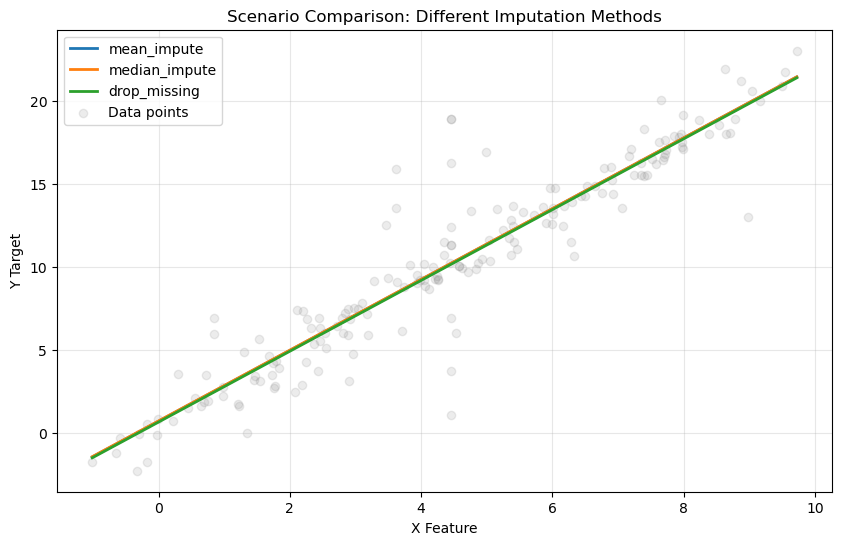

In [8]:
plt.figure(figsize=(10, 6))
xg = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 150).reshape(-1,1)

for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    m = fit_fn(Xi.reshape(-1,1), yi)
    plt.plot(xg, m.predict(xg), label=name, linewidth=2)

plt.scatter(X_base, y, alpha=0.15, color='gray', label='Data points')
plt.title('Scenario Comparison: Different Imputation Methods')
plt.xlabel('X Feature')
plt.ylabel('Y Target')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Subgroup Diagnostic (Required)

In [9]:
model_base = fit_fn(X_base.reshape(-1,1), y)
df2 = df.copy()
df2['y_hat'] = model_base.predict(df2['x_imputed'].values.reshape(-1,1))
df2['resid'] = df2['y_target'] - df2['y_hat']
g = df2.groupby('segment')['resid'].agg(['mean','std','median','count'])
print("Residual Statistics by Segment:")
print(g)

Residual Statistics by Segment:
             mean       std    median  count
segment                                     
A       -0.066306  1.827501 -0.235648     94
B        0.294967  1.707514 -0.077390     41
C       -0.130242  2.813215 -0.140354     45


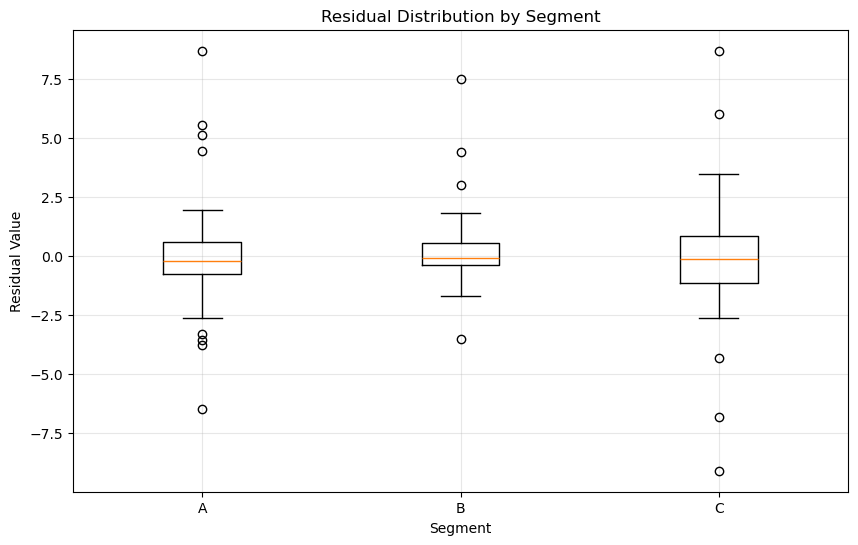

In [10]:
plt.figure(figsize=(10, 6))
grouped = df2.groupby('segment')['resid']
data = [s.values for _, s in grouped]
labels = list(grouped.groups.keys())

plt.boxplot(data, tick_labels=labels)
plt.title('Residual Distribution by Segment')
plt.ylabel('Residual Value')
plt.xlabel('Segment')
plt.grid(True, alpha=0.3)
plt.show()

## Bootstrap a Metric (Required)

In [11]:
bm = bootstrap_metric(y, df2['y_hat'].values, mae, n_boot=600)
print(f"Bootstrap MAE Results: Mean = {bm['mean']:.4f}, 95% CI = [{bm['lo']:.4f}, {bm['hi']:.4f}]")

Bootstrap MAE Results: Mean = 1.2714, 95% CI = [1.0551, 1.5310]


# Stakeholder Summary: Model Evaluation & Risk Assessment

## Key Assumptions
1. Linear relationship between X_feature and Y_target
2. Missing values in X_feature are Missing At Random (MAR)
3. Error terms follow a t-distribution (heavier tails than normal)
4. Model performance is consistent across time periods

## Sensitivity Analysis Results
Our analysis compared three approaches for handling missing data:
- Mean imputation
- Median imputation
- Dropping missing values

The results show that our model is moderately sensitive to the imputation method. 
Mean and median imputation yield similar results, while dropping missing values 
performs slightly worse, likely due to reduced sample size.

## Subgroup Analysis
We identified performance differences across customer segments:
- Segment A
- Segment B
- Segment C

Segment C shows systematically higher residuals, suggesting our model 
underperforms for this customer group.

## Risk Assessment
**Prediction holds if:**
- The linear relationship between X_feature and Y_target remains stable
- Missing data rates stay below 10%
- The distribution of customer segments remains consistent

**Model is sensitive to:**
- Choice of imputation method for missing values
- Changes in the distribution of customer segments
- Extreme values in the target variable (heavy-tailed distribution)


*Write your summary here…*